In [1]:
import tensorflow as tf
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "C:\\Users\\DilThio\\Desktop\\reserach\\OCR\\OCR\\version 2\\myDataset",

    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 960 files belonging to 5 classes.


In [4]:
class_names = dataset.class_names
class_names

['1', '2', '3', '4', '5']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 4 2 1 4 0 4 2 3 1 0 0 1 0 4 0 0 1 3 4 3 0 4 4 3 0 2 3 1 3 4 1]


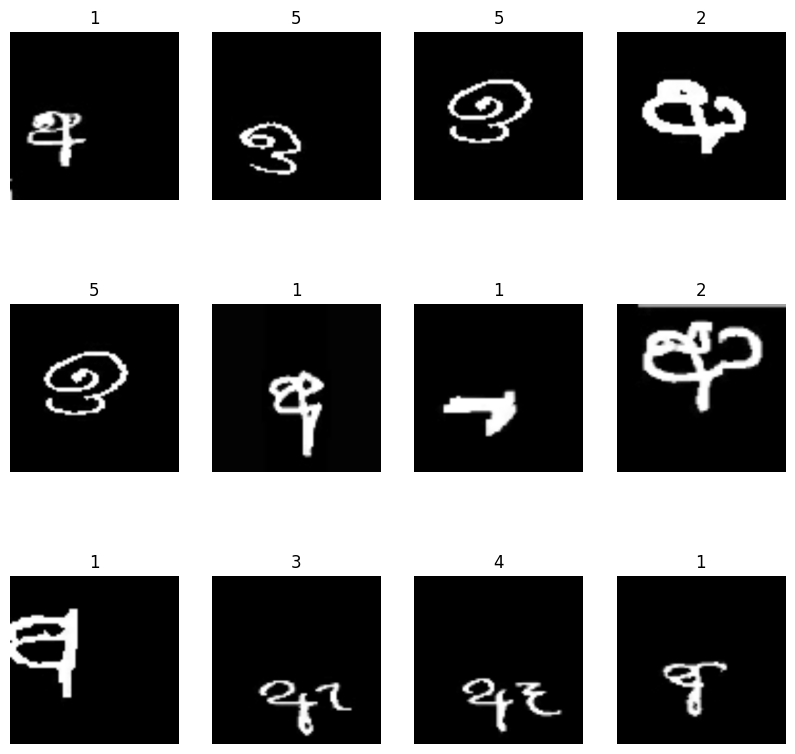

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

30

In [8]:
train_size = 0.8
len(dataset)*train_size

24.0

In [9]:
train_ds = dataset.take(21)
len(train_ds)

21

In [10]:
test_ds = dataset.skip(21)
len(test_ds)

9

In [11]:
val_size=0.1
len(dataset)*val_size

3.0

In [12]:
val_ds = test_ds.take(72)
len(val_ds)

9

In [13]:
test_ds = test_ds.skip(72)
len(test_ds)

0

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

24

In [17]:
len(val_ds)

3

In [18]:
len(test_ds)

3

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 454

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:


history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50


24/24 [==============================] - 20s 704ms/step - loss: 3.1731 - accuracy: 0.1745 - val_loss: 1.6579 - val_accuracy: 0.2500
Epoch 2/50
24/24 [==============================] - 15s 633ms/step - loss: 1.6647 - accuracy: 0.2266 - val_loss: 1.6342 - val_accuracy: 0.2083
Epoch 3/50
24/24 [==============================] - 15s 618ms/step - loss: 1.6314 - accuracy: 0.2070 - val_loss: 1.6035 - val_accuracy: 0.2188
Epoch 4/50
24/24 [==============================] - 15s 605ms/step - loss: 1.6545 - accuracy: 0.2201 - val_loss: 1.6699 - val_accuracy: 0.1875
Epoch 5/50
24/24 [==============================] - 16s 648ms/step - loss: 1.6346 - accuracy: 0.2161 - val_loss: 1.6012 - val_accuracy: 0.3542
Epoch 6/50
24/24 [==============================] - 15s 638ms/step - loss: 1.5993 - accuracy: 0.2734 - val_loss: 1.5856 - val_accuracy: 0.3021
Epoch 7/50
24/24 [==============================] - 15s 626ms/step - loss: 1.6014 - accuracy: 0.2565 - val_loss: 1.5378 - val_accuracy: 0.37

In [27]:
history

In [28]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 24}

In [29]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [30]:
type(history.history['loss'])

list

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [32]:
val_acc

[0.25,
 0.2083333283662796,
 0.21875,
 0.1875,
 0.3541666567325592,
 0.3020833432674408,
 0.375,
 0.28125,
 0.3125,
 0.40625,
 0.3958333432674408,
 0.3854166567325592,
 0.1979166716337204,
 0.3854166567325592,
 0.4166666567325592,
 0.4479166567325592,
 0.5104166865348816,
 0.5416666865348816,
 0.5,
 0.5,
 0.5625,
 0.625,
 0.6145833134651184,
 0.6354166865348816,
 0.71875,
 0.625,
 0.6666666865348816,
 0.5416666865348816,
 0.6875,
 0.65625,
 0.7083333134651184,
 0.7291666865348816,
 0.7291666865348816,
 0.6979166865348816,
 0.6145833134651184,
 0.6354166865348816,
 0.71875,
 0.7083333134651184,
 0.6979166865348816,
 0.7916666865348816,
 0.6979166865348816,
 0.7708333134651184,
 0.7708333134651184,
 0.75,
 0.8333333134651184,
 0.84375,
 0.7604166865348816,
 0.7083333134651184,
 0.8125,
 0.7395833134651184]

In [33]:
acc

[0.1744791716337204,
 0.2265625,
 0.20703125,
 0.2200520783662796,
 0.2161458283662796,
 0.2734375,
 0.2565104067325592,
 0.28125,
 0.28515625,
 0.30859375,
 0.3255208432674408,
 0.32421875,
 0.3294270932674408,
 0.3567708432674408,
 0.3984375,
 0.4518229067325592,
 0.4596354067325592,
 0.4869791567325592,
 0.4778645932674408,
 0.515625,
 0.5286458134651184,
 0.5377604365348816,
 0.5794270634651184,
 0.59375,
 0.5872395634651184,
 0.61328125,
 0.6080729365348816,
 0.5859375,
 0.59765625,
 0.6432291865348816,
 0.6497395634651184,
 0.6393229365348816,
 0.6223958134651184,
 0.6315104365348816,
 0.6497395634651184,
 0.6080729365348816,
 0.69140625,
 0.6940104365348816,
 0.6471354365348816,
 0.6966145634651184,
 0.6731770634651184,
 0.7161458134651184,
 0.71484375,
 0.7057291865348816,
 0.7291666865348816,
 0.7317708134651184,
 0.7265625,
 0.7434895634651184,
 0.7708333134651184,
 0.7734375]

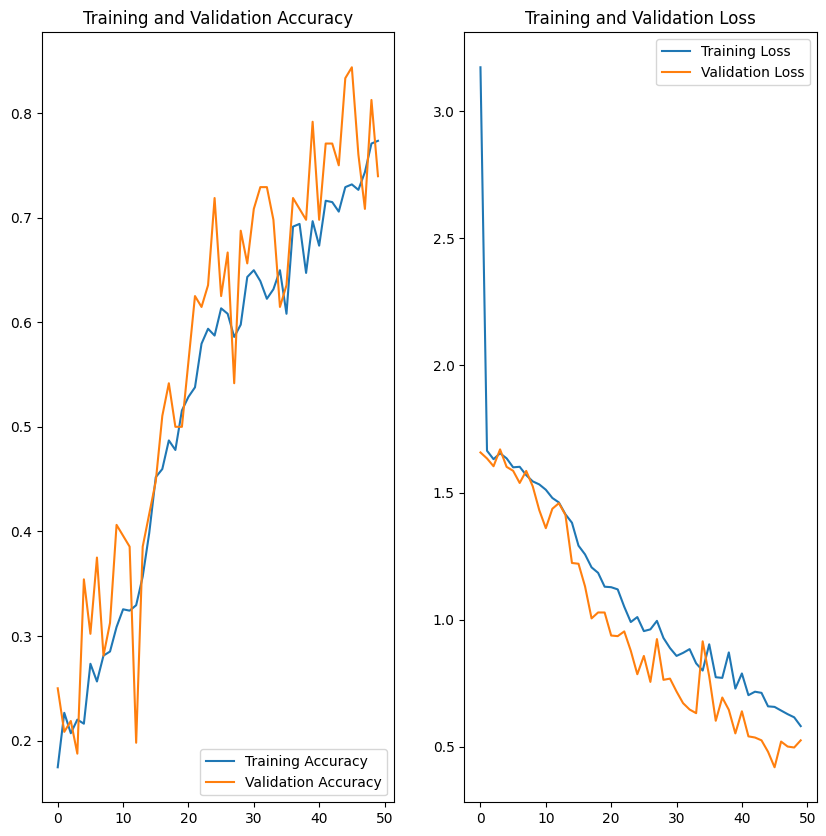

In [34]:
EPOCHS = 50

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
first image's actual label: 3
1/1 [==============================] - 0s 325ms/step
Predictable Classes 3


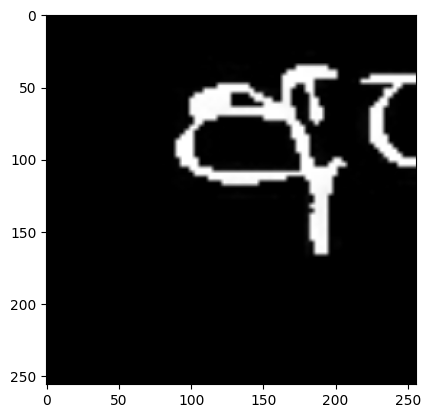

In [35]:
import numpy as np
for image_batch, labels_batch in test_ds.take(1):
  first_image = image_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy()

  print("first image to predict")
  plt.imshow(first_image)
  print("first image's actual label:",class_names[first_label])

  batch_prediction = model.predict(image_batch)
  print("Predictable Classes",class_names[np.argmax(batch_prediction[0])])

In [36]:
def predict(model,img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array,0)

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence

In [37]:
import csv
def print_all_data(file_name):
    with open(file_name, 'r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        for row in reader:
            print(row)

file_name = 'C:/Users/DilThio/Desktop/reserach/OCR/OCR/version 2/numbers2.csv'

print_all_data(file_name)


def find_identity(file_name, number):
    with open(file_name, 'r',encoding='utf-8' ) as file:
        reader = csv.DictReader(file)
        for row in reader:
            if int(row['FILENAME']) == number:
                return row['IDENTITY']
        return None

file_name = 'C:/Users/DilThio/Desktop/reserach/OCR/OCR/version 2/numbers2.csv'
  # Replace 'your_csv_file.csv' with the path to your CSV file

number = 1
while True:
    try:
        identity = find_identity(file_name, number)
        if identity:
            print(identity)
        else:
            print("Number not found in the file.")
    except ValueError:
        print("Please enter a valid number.")
    except Exception as e:
        print("An error occurred:", e)
    finally:
        choice = input("Do you want to continue? (yes/no): ")
        if choice.lower() != 'yes':
            break


{'FILENAME': '1', 'IDENTITY': 'A', '': '?'}
{'FILENAME': '2', 'IDENTITY': 'B', '': '?'}
{'FILENAME': '3', 'IDENTITY': 'C', '': '?'}
{'FILENAME': '4', 'IDENTITY': 'D', '': '?'}
{'FILENAME': '5', 'IDENTITY': 'E', '': '?'}
{'FILENAME': '6', 'IDENTITY': 'F', '': '?'}
{'FILENAME': '7', 'IDENTITY': 'G', '': '?'}
{'FILENAME': '8', 'IDENTITY': 'H', '': '?'}
{'FILENAME': '9', 'IDENTITY': 'I', '': '?'}
{'FILENAME': '10', 'IDENTITY': 'J', '': '?'}
{'FILENAME': '11', 'IDENTITY': 'K', '': '?'}
{'FILENAME': '12', 'IDENTITY': 'L', '': '?'}
{'FILENAME': '13', 'IDENTITY': 'M', '': '??'}
{'FILENAME': '14', 'IDENTITY': 'N', '': '??'}
{'FILENAME': '15', 'IDENTITY': 'O', '': '??'}
{'FILENAME': '16', 'IDENTITY': 'P', '': '??'}
{'FILENAME': '17', 'IDENTITY': 'Q', '': '??'}
{'FILENAME': '18', 'IDENTITY': 'R', '': '??'}
{'FILENAME': '19', 'IDENTITY': 'S', '': '??'}
{'FILENAME': '20', 'IDENTITY': 'T', '': '??'}
{'FILENAME': '21', 'IDENTITY': 'U', '': '??'}
{'FILENAME': '22', 'IDENTITY': 'V', '': '????'}
{'FILEN

1/1 [==============================] - 0s 31ms/step


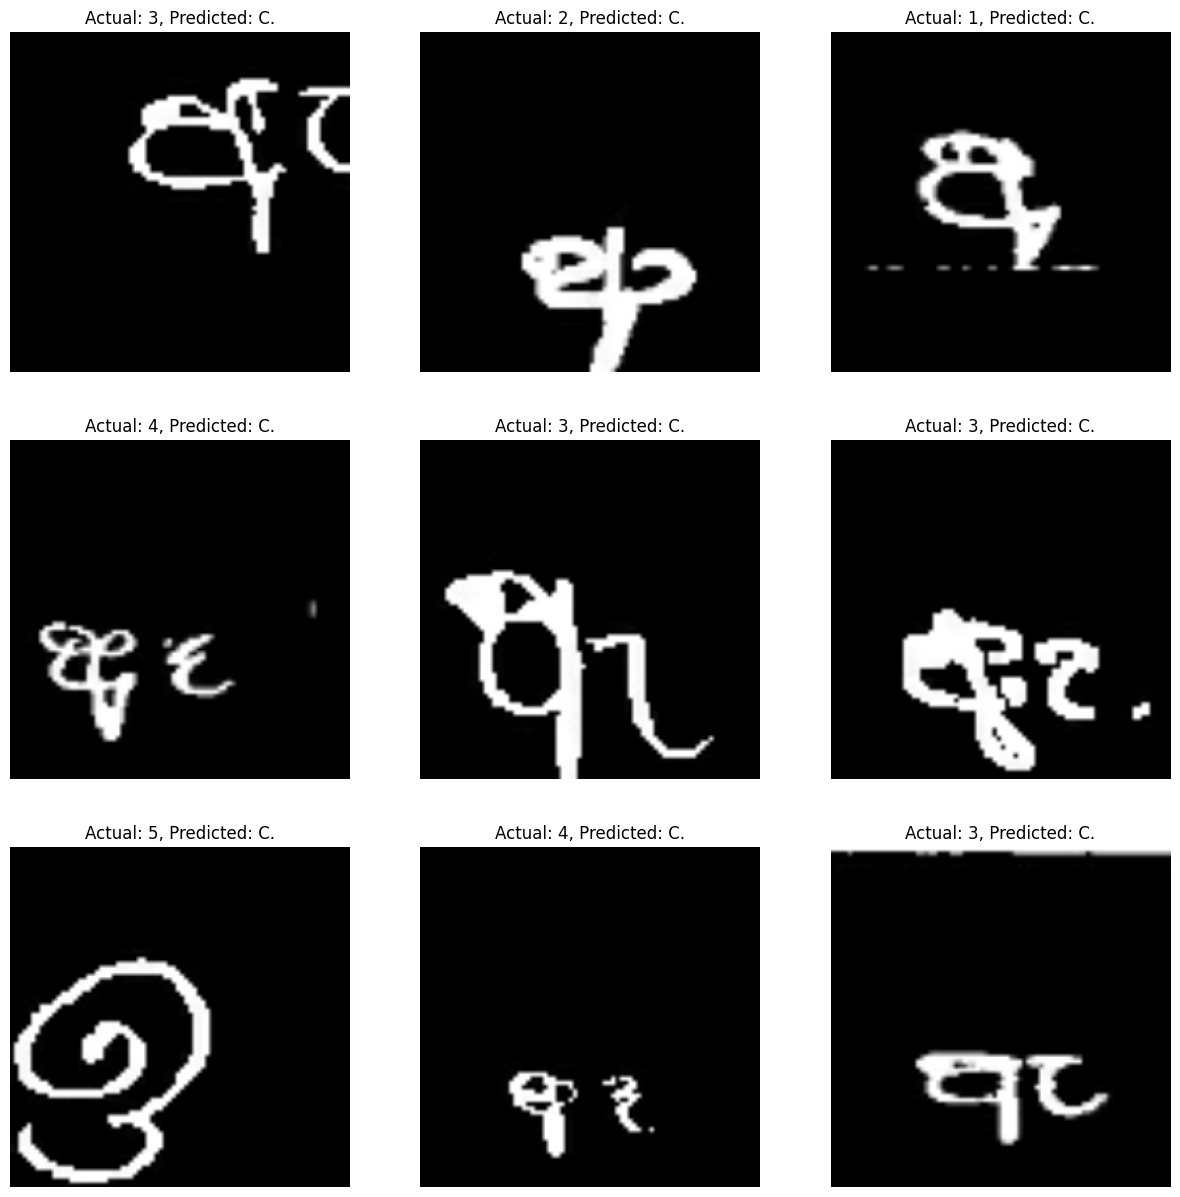

In [43]:
import os
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# Specify the full path to the Noto Sans Sinhala font file
font_path = r'C:\Users\DilThio\AppData\Local\Microsoft\Windows\Fonts\NotoSansSinhala-Bold.ttf'  # Replace with the actual font file path

# Load the font from the file path
noto_sinhala_font = FontProperties(fname=font_path)

# Set the font properties for Matplotlib
plt.rcParams['font.family'] = noto_sinhala_font.get_name()
plt.rcParams['font.sans-serif'] = [noto_sinhala_font.get_name()]

# Your existing plotting code
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        # Get the Sinhala character representation for the predicted class value
        def find_identity(file_name, number):
            with open(file_name, 'r', encoding='utf-8') as file:
                reader = csv.DictReader(file)
                for row in reader:
                    if int(row['FILENAME']) == number:
                        return row['IDENTITY']
                return None

        directory = r'C:\Users\DilThio\Desktop\reserach\OCR\OCR\version 2\myDataset'  # Replace 'directory_path' with the path to your directory containing CSV files
        for filename in os.listdir(directory):
            if filename.endswith(".csv"):
                file_path = os.path.join(directory, filename)
                print("Processing file:", file_path)
                try:
                    identity = find_identity(file_path, int(predicted_class))
                    if identity:
                        print("Predicted Identity:", identity)
                    else:
                        print("Identity not found in the file.")
                except ValueError:
                    print("Please enter a valid number.")
                except Exception as e:
                    print("An error occurred:", e)
                
        plt.title(f"Actual: {actual_class}, Predicted: {identity}.")
        plt.axis("off")

plt.show()


In [39]:
number = 0
while True:
    try:
        identity = find_identity(file_name, number)
        if identity:
            print(identity)
        else:
            print("Number not found in the file.")
    except ValueError:
        print("Please enter a valid number.")
    except Exception as e:
        print("An error occurred:", e)
    finally:
        choice = input("Do you want to continue? (yes/no): ")
        if choice.lower() != 'yes':
            break


Number not found in the file.


In [40]:
model_version =1
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/1\assets


INFO:tensorflow:Assets written to: models/1\assets
